In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ind2gen(index,n):
    '''Return a genotype of length n that encodes the index in binary'''
    # For example, ind2gen(255,8) = [1, 1, 1, 1, 1, 1, 1, 1]
    genotype = np.zeros(n)
    if index >= 2**n:
        print("ind2gen error")
        return genotype
    while n > 0:
        n = n - 1
        if index % 2 == 0:
            genotype[n] = 0
        else:
            genotype[n] = 1
        index = index // 2
    return genotype

def gen2ind(genotype):
    '''Return the index encoded in the genotype'''
    # For example, gen2ind([1,1,1,1,1,1,1,1]) = 255
    i = 0
    index = 0
    mg = len(genotype)
    while i < mg:
        index += genotype[i]*(2**(mg-i-1))
        i += 1
    return int(index)

class Landscape:
    '''Create a tunably rugged landscape with N dimensions and K epistatic interactions'''

    def __init__(self, n, k):
        self.n = n
        self.maxfit = 0.0
        self.minfit = 1000000
        # Create random matrix for interactions
        # For example, when N = 5 and K = 1, there are 5 rows each with 4 columns
        # to score each combination of an individual and its neighbor (i.e. 01, 10, 11, 00)
        self.interactions = np.random.rand(n*(2**(k+1))).reshape(n,2**(k+1))
        self.fit_table = np.zeros(2**n)
        self.visited_table = np.zeros(2**n)
        self.best = 0
        for solution in range(2**n):      # Figure out fitness for each possible solution
            fit = 0
            genotype = ind2gen(solution,n)
            for gene in range(n):         # Calculate contribution of each gene in the current solution
                subgen = []
                for nbr in range(k+1):    # Identify neighbors
                    nbr_ind = (gene+nbr)%n
                    subgen.append(genotype[nbr_ind])
                ind = gen2ind(subgen)     # Calculate epistatic interactions with each neighbor
                fit += self.interactions[gene][ind]
            self.fit_table[solution] = fit
            if fit > self.maxfit:
                self.maxfit = fit
                self.best = genotype
            if fit < self.minfit:
                self.minfit = fit
        self.fit_table = (self.fit_table - self.minfit)/(self.maxfit-self.minfit) # Normalize
        self.fit_table = self.fit_table**8    # Scale????

    def howfit(self, genotype):
        '''Return the fitness of a solution.'''
        index = gen2ind(genotype)
        return self.fit_table[index]

In [3]:
class Generational():

    def __init__(self, fitnessFunction, popsize, genesize, recombProb, mutatProb, teachProb, eliteprop, generations,seed):
        self.popsize = popsize
        self.genesize = genesize
        self.fitnessFunction = fitnessFunction
        self.recombProb = recombProb
        self.mutatProb = mutatProb
        self.teachProb = teachProb
        self.elite = int(eliteprop*popsize)
        self.generations = generations
        self.learningops = np.vstack((np.zeros(genesize),np.identity(genesize)))
        learninit = np.zeros(genesize)
        self.seed = seed
        np.random.seed(self.seed)
        self.pop = np.random.randint(2, size=(popsize,3,genesize))
        self.pop[:,1,:]=learninit #the second "chromosome" is the state of the learned information
        for i in range(popsize):  #the third "chromosome" will be the aggregate of genes and learning, which will actually be used in the fitness function
            self.pop[i,2,:]=self.pop[i,0,:]
        self.fitness = np.zeros(popsize)
        self.rank = np.zeros(popsize,dtype=int)
        self.avgHistory = np.zeros(generations)
        self.bestHistory = np.zeros(generations)
        self.hammingHistory = np.zeros(generations)
        self.gen = 0
    
    def globalcalcFitness(self):
        for i in range(self.popsize):
            self.pop[i,2,:]=np.mod(sum([self.pop[i,0,:],self.pop[i,1,:]]),2)
            self.fitness[i]=self.fitnessFunction(self.pop[i,2,:])
    
    def localtestFitness(self,individual,locus):
        indiv=individual
        indiv[1,locus]=1
        indiv[2]=np.mod(sum([indiv[0],indiv[1]]),2)
        possiblefitness = self.fitnessFunction(indiv[2])
        return possiblefitness

    def showFitness(self):
        plt.plot(self.bestHistory)
        plt.plot(self.avgHistory)
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.title("Best and average fitness")

    def fitStats(self):
        bestind = self.pop[np.argmax(self.fitness),2,:]
        bestfit = np.max(self.fitness)
        avgfit = np.mean(self.fitness)
        avglearn = np.mean(np.sum(self.pop[:,1,:],1))
        self.avgHistory[self.gen]=avgfit
        self.bestHistory[self.gen]=bestfit
        return avgfit, bestfit, bestind, avglearn
    
    def hamdistCalc(self,hamm_compare):
        avghammdist = np.mean(np.sum(np.absolute(np.subtract(np.tile(hamm_compare,(popsize,1)),self.pop[:,0,:])),1))
        self.hammingHistory[self.gen]=avghammdist

    def run(self,hammtrue,hamm_comp):
        
        # Evolutionary loop
        for g in range(self.generations):
            
            # Opportunity for learning
            for i in range(self.popsize):
                education = np.zeros(len(self.learningops))
                education[0]=self.fitnessFunction(self.pop[i,2,:])
                for j in range(genesize):
                    if self.pop[i,1,j]==0:  #if there's not a learning switch there already,
                        education[j]=self.localtestFitness(self.pop[i],j)
                self.pop[i,1,:] = self.learningops[np.argmax(education)] #take info that gives max fitness, including if no additional info   

            #Recalculate fitness
            self.globalcalcFitness()
            
            # Report statistics every generation
            self.gen = g
            self.fitStats()
            if hammtrue:
                self.hamdistCalc(hamm_comp)
            
            # Rank individuals by fitness
            tempfitness = self.fitness.copy()
            for i in range(self.popsize):
                self.rank[i]=int(np.argmax(tempfitness))
                tempfitness[self.rank[i]]=0.0

            # Start new generation
            new_pop = np.zeros((self.popsize,3,self.genesize))
            new_fitness = np.zeros(self.popsize)

            # Fill out the elite first
            for i in range(self.elite):
                new_pop[i] = self.pop[self.rank[i]]
                new_fitness[i] = self.fitness[self.rank[i]]

            # Fill out remainder of the population through reproduction of most fit parents
            for i in range(self.elite,self.popsize):
                # Pick parents based on rank probability
                a = self.rank[int(np.random.triangular(0, 0, self.popsize))]
                b = self.rank[int(np.random.triangular(0, 0, self.popsize))]
                while (a==b):           # Make sure they are two different individuals
                    b = self.rank[int(np.random.triangular(0, 0, self.popsize))]

                # Recombine parents to produce child
                for k in range(self.genesize):
                    if np.random.random() < self.recombProb:
                        new_pop[i][0][k] = self.pop[a][0][k]
                        if np.random.random() < self.teachProb:
                            new_pop[i][1][k] = self.pop[a][1][k]  #if inherit gene, certain probability of also inherit learning
                    else:
                        new_pop[i][0][k] = self.pop[b][0][k]
                        if np.random.random() < self.teachProb:
                            new_pop[i][1][k] = self.pop[b][1][k]

                # Mutate child and make sure they stay within bounds
                for k in range(self.genesize):
                    if (np.random.random() < self.mutatProb):
                        new_pop[i][0][k] = np.mod(self.pop[i][0][k]+1,2)  #change the 0 to 1 and vice versa
                        new_pop[i][1][k] = 0   #reset the learning at that locus                       
                

            # Finally, replace old population with the new one
            self.pop = new_pop.copy()
            self.fitness = new_fitness.copy()
            

In [4]:
##Set Parameters and landscape and re-seed

ruggedness=5
popsize=60
genesize=12
recombProb=.5
mutatProb=.075
teachProb=.75
eliteprop=3/4
generations=150
seed = np.random.randint(1,3000)
fitnessLandscape = Landscape(genesize,ruggedness)

(0.4130761926959477,
 0.6053107109407744,
 array([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.]),
 0.7166666666666667)

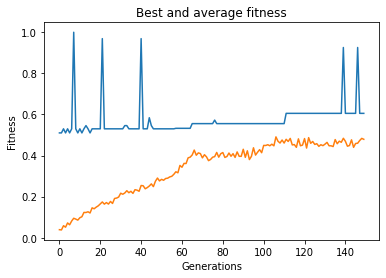

In [5]:
##Run GA and show fitness evolution

trial = Generational(fitnessLandscape.howfit, popsize, genesize, recombProb, mutatProb, .9975, eliteprop, generations, seed)
trial.run(0,0)
#trial.__init__(fitnessLandscape.howfit, popsize, genesize, recombProb, mutatProb, teachProb, eliteprop, generations, seed)
#trial.run(1,)
trial.showFitness()
trial.fitStats()

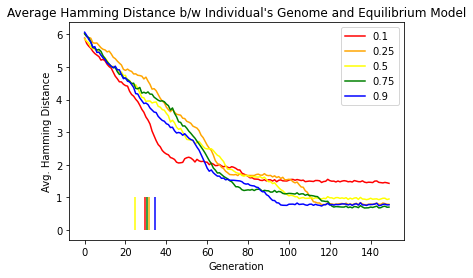

In [104]:
##Main Experiment

teachvals = [.1,.25,.5,.75,.9]
num_runs = len(teachvals)
Hammingruns = np.zeros((num_runs,generations))
wheneqattained = np.zeros(num_runs)
reps = 10
rep = 0
for rep in range(reps):
    seed = np.random.randint(1,3000)
    for i in range(num_runs):
        trial = Generational(fitnessLandscape.howfit, popsize, genesize, recombProb, mutatProb, teachvals[i], eliteprop, generations, seed)
        trial.__init__(fitnessLandscape.howfit, popsize, genesize, recombProb, mutatProb, teachvals[i], eliteprop, generations, seed)
        trial.run(0,0)
        equilibrium_model = trial.fitStats()[2]
        instances = np.where(trial.bestHistory==trial.fitStats()[1])[0]
        breaks = np.ediff1d(instances)
        start_equilibrium = 0
        for j in range(len(breaks)):
            if breaks[j]==breaks[j+1]==breaks[j+2]==breaks[j+3]==breaks[j+4]==breaks[j+5]==breaks[j+6]==breaks[j+7]==breaks[j+8]==breaks[j+9]:
                start_equilibrium = instances[j]
                break
        wheneqattained[i]=wheneqattained[i]+start_equilibrium
        trial.__init__(fitnessLandscape.howfit, popsize, genesize, recombProb, mutatProb, teachvals[i], eliteprop, generations, seed)
        trial.run(1,equilibrium_model)
        Hammingruns[i]=np.add(trial.hammingHistory,Hammingruns[i])
    #print(Hammingruns)
    #print(wheneqattained)
    rep += 1
for i in range(len(Hammingruns)):
    Hammingruns[i] = Hammingruns[i]/reps  #normalize to take the average
    wheneqattained[i] = wheneqattained[i]/reps
rainbow = ["red",'orange','yellow','green','blue']       
fig, ax = plt.subplots()
for i in range(len(teachvals)):
    ax.plot(Hammingruns[i],color=rainbow[i])
ax.vlines(wheneqattained,0,1,colors=rainbow)
ax.set_title("Average Hamming Distance b/w Individual's Genome and Equilibrium Model")
ax.set_xlabel("Generation")
ax.set_ylabel("Avg. Hamming Distance")
ax.legend(labels=teachvals)